# 2．線形回帰モデルを通して｢解釈性｣を理解する

* 線形回帰モデルが備える解釈性
    1. 特徴量と予測値の平均的な関係
    2. 特徴量と予測値のインスタンスごとの関係
    3. 特徴量の重要度
    4. インスタンスごとの予測の理由

1. 特徴量と予測値の平均的な関係
2. 特徴量と予測値のインスタンスごとの関係
3. 特徴量の重要度
4. インスタンスごとの予測の理由

In [76]:
import sys
import warnings
from dataclasses import dataclass
import joblib

import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

warnings.simplefilter('ignore')

In [2]:
# load data
boston = load_boston()
X = pd.DataFrame(data=boston['data'], columns=boston['feature_names'])
y = boston['target']

print(X.shape)
print(y.shape)

(506, 13)
(506,)


In [5]:
X.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


- `CRIM`     per capita crime rate by town
- `ZN`       proportion of residential land zoned for lots over 25,000 sq.ft.
- `INDUS`    proportion of non-retail business acres per town
- `CHAS`     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- `NOX`      nitric oxides concentration (parts per 10 million)
- `RM`      average number of rooms per dwelling
- `AGE`      proportion of owner-occupied units built prior to 1940
- `DIS`      weighted distances to five Boston employment centres
- `RAD`      index of accessibility to radial highways
- `TAX`      full-value property-tax rate per $10,000
- `PTRATIO`  pupil-teacher ratio by town
- `B`        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- `LSTAT`    % lower status of the population
- `MEDV`     Median value of owner-occupied homes in \$1000's

In [3]:
def plot_histgram(x, title=None, x_label=None):
    fig, ax = plt.subplots()
    # sns.distplot(x, kde=False, ax=ax)
    ax.hist(x, bins=30, ec='black')
    fig.suptitle(title)
    ax.set_xlabel(x_label)
    
    fig.show()

目的変数：地域ごとの住宅価格の中央値

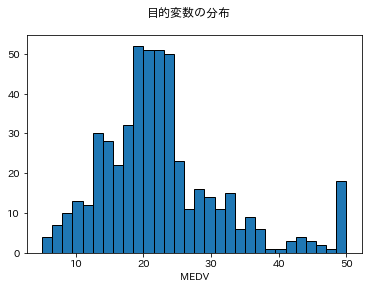

In [4]:
plot_histgram(y, title='目的変数の分布', x_label='MEDV')

- 少し右に長い分布になっていて，正規分布から少し歪んでいるようにも見える
    - 目的変数の対数を取ってから回帰モデルを当てはめると予測がうまく行く可能性があるが，回帰係数の解釈が若干複雑になる
- 50付近で分布の山が高くなっていくことが分かる
    - 50を越えたらその値にまとめてある？(トップコーディング)
    - トップコーディングが行われたデータに対する回帰モデルとして，打ち切り回帰モデルが知られている

注目する特徴量
- `RM`:平均的な部屋の数
- `LSTAT`:地域の低所得層の割合
- `DIS`:都心からの距離
- `CRIM`:犯罪率

In [18]:
def plot_scatter(X, y, title=None):
    """
    目的変数と特徴量の散布図の作成
    """
    cols = X.columns
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))
    for ax, c in zip(axes.ravel(), cols):
        ax.scatter(X[c], y)
        ax.set_ylabel('MEDV')
        ax.grid()
    fig.suptitle(title)
    fig.show()

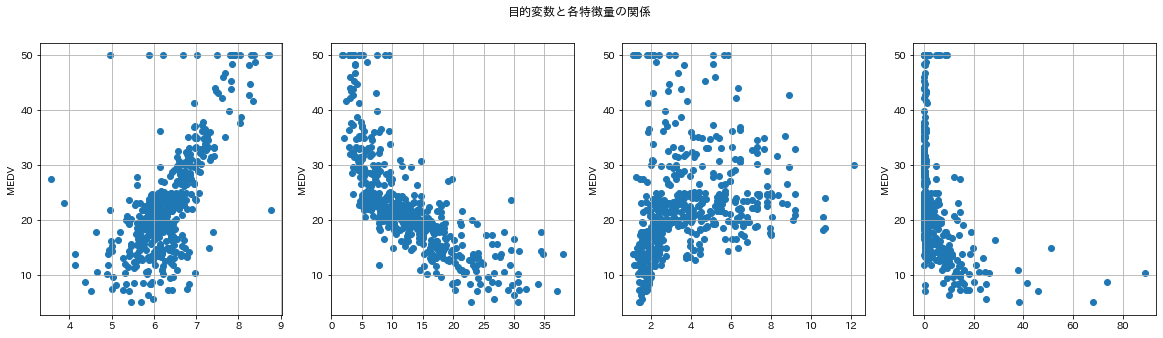

In [19]:
use_cols = ['RM', 'LSTAT', 'DIS', 'CRIM']
title = '目的変数と各特徴量の関係'
plot_scatter(X[use_cols], y, title=title)

In [21]:
# 訓練データとテストデータに分割

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [24]:
# 書き出し

joblib.dump(
    [X_train, X_test, y_train, y_test],
    filename = 'data/boston_housing.pickle')

['data/boston_housing.pickle']

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

Root Mean Squared Error ... 誤差の平均(小さいほど良い)

$$
RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i - \hat{y_i})^2}
$$

$R^2$(R-squared) ... モデルがデータをどの程度説明できているのか(大きいほど良い)

$$
R^2 = 1 - \frac{\sum_{i=1}^{N}(y_i - \hat{y_i})^2}{\sum_{i=1}^{N}(y_i - \bar{y_i})^2}
$$

In [31]:
def regression_metrics(estimator, X, y):
    """
    回帰精度の評価指標をまとめて返す関数
    """
    # テストデータで予測
    y_pred = estimator.predict(X)
    # 評価指標をデータフレームにまとめる
    df = pd.DataFrame(
        data = {
            'RMSE': [mean_squared_error(y, y_pred, squared=False)],
            'R2': [r2_score(y, y_pred)]})
    return df

In [32]:
regression_metrics(model, X_test, y_test)

,RMSE,R2
0,4.928602,0.668759


- 平均的には予測を4.93だけ外している
- 平均では予測できなかった住宅価格のばらつきのうち約67%を予測できていることが見てとれる

モデルの解釈

In [34]:
def get_coef(estimator, var_names):
    """
    特徴量名と回帰係数が対応したデータフレームを作成する
    """
    # 切片含む回帰係数と特徴量の名前を抜き出してデータフレームにまとめる
    df = pd.DataFrame(
        data = {'coef': [estimator.intercept_] + estimator.coef_.tolist()},
        index = ['intercept'] + var_names)
    return df

In [36]:
# 回帰係数の取り出し
df_coef = get_coef(model, X.columns.tolist())
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.246751,-0.113056,0.03011,0.040381,2.784438,-17.202633,4.438835,-0.006296,-1.447865,0.26243,-0.010647,-0.915456,0.012351,-0.508571


In [37]:
X_train2 = X_train.copy()
X_test2 = X_test.copy()

In [41]:
# 二乗項を追加
X_train2['LSTAT2'] = X_test2['LSTAT'] ** 2 
X_test2['LSTAT2'] = X_test2['LSTAT'] ** 2

# 学習
model2 = LinearRegression()
model2.fit(X_test2, y_test)

# 精度評価
regression_metrics(model2, X_test2, y_test)

,RMSE,R2
0,3.775386,0.805635


In [42]:
# もともと
# RMSE	R2
# 4.928602	0.668759

# 変数追加後
# RMSE	R2
# 3.775386	0.805635

- 特徴量を追加することによって，予測精度が改善した 

In [45]:
# 回帰係数
print('もともと')
display(df_coef.T)
df_coef2 = get_coef(model2, X_train2.columns.tolist())
print('変数追加後')
display(df_coef2.T)

もともと


,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.246751,-0.113056,0.03011,0.040381,2.784438,-17.202633,4.438835,-0.006296,-1.447865,0.26243,-0.010647,-0.915456,0.012351,-0.508571


変数追加後


,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,LSTAT2
coef,60.009875,-0.361805,0.066954,0.09521,1.343053,-20.532052,1.462291,0.064274,-0.97306,0.453484,-0.015133,-1.010772,-0.000655,-1.911417,0.039656


LSTATの回帰係数は`-1.92`，二乗項の係数は`0.03`なので，LSTATが1単位大きくなったときに予測値に与える影響は，$f(X)=\alpha X + \beta X^2$のとき，$\frac{\partial f(X)}{\partial X} = \alpha + 2 \times \beta \times LSTAT$であるから

$$
-1.91 + 2 \times 0.03 \times LSTAT
$$

であるから，LSTATが1単位増加した際に予測値に与えるマイナスの影響は，元々のLSTATの水準が高くなればなるほど(絶対値で見て)小さくなることが分かる

In [60]:
def calc_lstat_impact(df_coef, lstat):
    """
    LSTATAが1単位増加したときに予測値に影響
    """
    return (df_coef.loc['LSTAT'] + 2 * df_coef.loc['LSTAT2'] * lstat).values[0]

In [61]:
i = 274
lstat = X_test2.loc[i, 'LSTAT']
impact = calc_lstat_impact(df_coef2, lstat)
print(f"LSTAT_coef = {df_coef2.loc['LSTAT'].values[0]:.2f}")
print(f"index={i}においてLSTATが1単位増加したときの効果(LSTAT={lstat:.2f}) : {impact:.2f}")

LSTAT_coef = -1.91
index=274においてLSTATが1単位増加したときの効果(LSTAT=3.53) : -1.63


In [62]:
i = 491
lstat = X_test2.loc[i, 'LSTAT']
impact = calc_lstat_impact(df_coef2, lstat)
print(f"LSTAT_coef = {df_coef2.loc['LSTAT'].values[0]:.2f}")
print(f"index={i}においてLSTATが1単位増加したときの効果(LSTAT={lstat:.2f}) : {impact:.2f}")

LSTAT_coef = -1.91
index=491においてLSTATが1単位増加したときの効果(LSTAT=18.07) : -0.48


- LSTATの水準が高いインスタンス491の方が，LSTATの水準が低いインスタンス274と比較して，LSTATが1単位増加したときの効果が小さくなっている
    - 低所得者層の割合が高いインスタンスにおいては低所得者層の割合が増加したとしても予測値に与える影響が小さい
    - 低所得者の割合が低いインスタンスにおいては低所得者層の割合が増加すると予測値に与える影響が大きい

In [63]:
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.246751,-0.113056,0.03011,0.040381,2.784438,-17.202633,4.438835,-0.006296,-1.447865,0.26243,-0.010647,-0.915456,0.012351,-0.508571


- NOX(酸化窒素濃度)の回帰係数の絶対値が最も大きいが，モデルにとってもっとも重要な変数かと言われると，そうではない

In [65]:
print(f"{X['RM'].min()} ~ {X['RM'].max()}")
print(f"{X['NOX'].min()} ~ {X['NOX'].max()}")

3.561 ~ 8.78
0.385 ~ 0.871


それぞれの特徴量は最小〜最大の値のスケールがことなるため，1単位増加の意味合いが統一されていない→標準化する

特徴量の標準化

$$
\tilde{x_i} = \frac{x_i - \bar{x}}{SD(x)} \\
\hat{x} = \frac{1}{N} \sum_{i=1}^{N} x_i, \\
SD(x) = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_i - \bar{x})^2}
$$

In [67]:
# 訓練データから平均と分散を計算
ss = StandardScaler()
ss.fit(X_train)

# 標準化：平均を引いて標準偏差で割る
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

# 学習
model_ss = LinearRegression()
model_ss.fit(X_train_ss, y_train)

# 精度評価
regression_metrics(model_ss, X_test_ss, y_test)

,RMSE,R2
0,4.928602,0.668759


In [68]:
df_coef_ss = get_coef(model_ss, X_train.columns.tolist())
df_coef_ss.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,22.796535,-1.002135,0.696269,0.278065,0.718738,-2.022319,3.14524,-0.176048,-3.081908,2.251407,-1.767014,-2.037752,1.129568,-3.611658


- 標準化後の回帰係数は`RM > NOX`となった

予測の理由：｢線形回帰モデルがなぜこの予測値を出したのか｣を説明する

In [73]:
# 先頭のインスタンス
X_i = X_test.iloc[[0]]

print(f"インスタンス{X_i.index[0]}に対する予測値：{model.predict(X_i)[0]:.2f}")

インスタンス173に対する予測値：29.00


In [74]:
X_i

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
173,0.09178,0.0,4.05,0.0,0.51,6.416,84.1,2.6463,5.0,296.0,16.6,395.5,9.04


回帰係数を用いれば予測の理由が完璧に分かる

In [75]:
df_coef.T

,intercept,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
coef,30.246751,-0.113056,0.03011,0.040381,2.784438,-17.202633,4.438835,-0.006296,-1.447865,0.26243,-0.010647,-0.915456,0.012351,-0.508571


ランダムフォレストによる予測

- `n_estimator`:アンサンブルに用いる決定木の総数．基本的に多くすれば予測精度は高くなるが，学習と予測の測度は遅くなる．決定木を追加する効果は逓減していくので，あまり多くても
時間がかかるだけで得られるメリットは少なくなる．デフォルトでは100．予測精度を上げたい場合は，グリッドサーチなどで探索するのではなく，十分に大きな値で決め打ちする．
- `min_samples_in_leaf`:ひとつひとつの決定木の最終ノードに含まれるインスタンス数の下限を指定．デフォルトでは1．大きくするとオーバーフィットを防げるが，大きすぎるとアンダーフィットする．副作用として，ひとつひとつの決定木の分割が小さくなる分，木が浅くなり計算時間が短縮される．グリッドサーチで探索するべきパラメータ
- `max_features`:分割の際にランダムに選ばれる特徴量の候補を絶対数または割合で指定できる．分割できる特徴量を一部に限定することで決定木ごとの相関小さくすることが目的．
デフォルトだと全特徴量が候補となる．予測精度を上げたい場合は，グリッドサーチなどで探索すると良い

In [78]:
# Random Forestの学習
# n_jobs == -1 で利用可能な全てのCPUを使って計算を並列化する

rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
# モデルの書き出し
joblib.dump(rf, "data/boston_house_rf.pkl")
# 精度評価
regression_metrics(rf, X_test, y_test)

,RMSE,R2
0,2.810963,0.892253


In [79]:
# 予測精度は高くなった

# RMSE	R2
# 4.928602	0.668759